In [27]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target


In [28]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)


In [29]:
def forward_feature_selection(X, y):
    n_features = X.shape[1]
    best_features = []
    best_mse = np.inf
    
    for i in range(n_features):
        candidate_features = list(set(range(n_features)) - set(best_features))
        mse_list = []
        
        for feature in candidate_features:
            features = best_features + [feature]
            X_subset = X.iloc[:, features]
            X_subset = (X_subset - X_subset.mean()) / X_subset.std()  # standardize the features
            X_subset = np.hstack((np.ones((X_subset.shape[0], 1)), X_subset))  # add intercept
            beta = np.linalg.inv(X_subset.T @ X_subset) @ X_subset.T @ y  # calculate beta using OLS
            y_pred = X_subset @ beta  # calculate predictions
            mse_list.append(mse(y, y_pred))
            
        best_feature_idx = np.argmin(mse_list)
        best_features.append(candidate_features[best_feature_idx])
        best_mse = mse_list[best_feature_idx]
        
    return best_features, best_mse


In [30]:
best_features, best_mse = forward_feature_selection(X, y)
print('Best features:', best_features)
print('Best MSE:', best_mse)


Best features: [2, 8, 3, 4, 1, 5, 7, 9, 6, 0]
Best MSE: 2859.69634758675


In [31]:
def backward_feature_selection(X, y):
    n_features = X.shape[1]
    features = list(range(n_features))
    best_mse = np.inf
    
    while len(features) > 0:
        mse_list = []
        
        for feature in features:
            remaining_features = list(set(features) - set([feature]))
            X_subset = X.iloc[:, remaining_features]
            X_subset = (X_subset - X_subset.mean()) / X_subset.std()  # standardize the features
            X_subset = np.hstack((np.ones((X_subset.shape[0], 1)), X_subset))  # add intercept
            beta = np.linalg.inv(X_subset.T @ X_subset) @ X_subset.T @ y  # calculate beta using OLS
            y_pred = X_subset @ beta  # calculate predictions
            mse_list.append(mse(y, y_pred))
            
        worst_feature_idx = np.argmax(mse_list)
        worst_feature = features[worst_feature_idx]
        features.remove(worst_feature)
    
        if mse_list[worst_feature_idx] < best_mse:
            best_mse = mse_list[worst_feature_idx]
            best_features = features[:]
        
    return best_features, best_mse

In [32]:
best_features, best_mse = backward_feature_selection(X, y)
print('Best features:', best_features)
print('Best MSE:', best_mse)

Best features: [0, 1, 3, 4, 5, 6, 7, 8, 9]
Best MSE: 3264.7494018838033


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X_forward = X.iloc[:, best_features]
X_backward = X.iloc[:, best_features[::-1]]

lr_forward = LinearRegression()
lr_backward = LinearRegression()

mse_forward = -cross_val_score(lr_forward, X_forward, y, cv=10, scoring='neg_mean_squared_error').mean()
mse_backward = -cross_val_score(lr_backward, X_backward, y, cv=10, scoring='neg_mean_squared_error').mean()

print('MSE using forward selection:', mse_forward)
print('MSE using backward selection:', mse_backward)


MSE using forward selection: 3437.2045499504034
MSE using backward selection: 3437.2045499504043


In [34]:
import matplotlib.pyplot as plt

def plot_mse_vs_features(X, y, selected_features):
    mse_values = []
    num_features = range(1, len(selected_features) + 1)
    
    for k in num_features:
        lr = LinearRegression()
        mse = -cross_val_score(lr, X.iloc[:, selected_features[:k]], y, cv=10, scoring='neg_mean_squared_error').mean()
        mse_values.append(mse)
        
    plt.plot(num_features, mse_values, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('MSE')
    plt.title('MSE vs. Number of Features')
    plt.show()


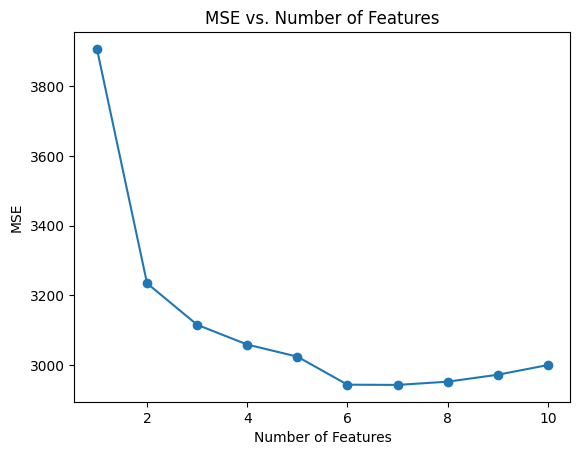

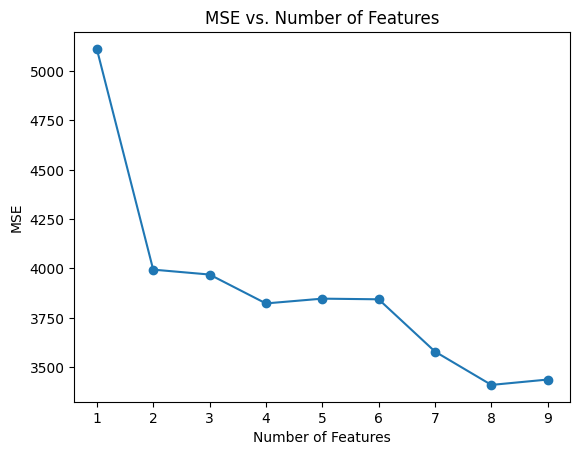

In [35]:
best_forward_features, _ = forward_feature_selection(X, y)
plot_mse_vs_features(X, y, best_forward_features)

best_backward_features, _ = backward_feature_selection(X, y)
plot_mse_vs_features(X, y, best_backward_features[::-1])
